In [1]:
import scipy.sparse.linalg
import numpy as np
import matplotlib as plt
import seaborn as sns
import math
import pandas as pd
from scipy.stats import chisquare, variation, kstwobign, norm, lognorm
import scipy.stats as stats

In [2]:
# update function / expected score
def exp_score(R_A, R_B):
    return (1 /(1+10**((R_B-R_A)/400)))

In [3]:
# win probability function
def w_fct(s_a, s_b):
    return (1 /(1+10**((s_b-s_a)/400)))

In [4]:
# compute variance of stat. dis.
def n_variance(p, n):
    v = 0
    for i in range(n*2+1):
        v += p[i] * ((i - (2*n)/2))**2
    return v

In [5]:
# transition matrix for uniform mm
def transitionmat_uf(n: int, c: int, k: int):
    tmat = np.zeros((2*n+1,2*n+1))
    for i in range (2*n+1):
        for j in range(i-c,i+c+1):
            e_s = exp_score(i, j)
            r_win = np.rint((1-e_s)*k)
            r_loss = np.rint(-(e_s)*k)
            win_state = int(min(2*n, i + r_win))
            loss_state = int(max(0, i + r_loss))
            tmat[i, win_state] = tmat[i, win_state]  + w_fct(0,j-n)
            tmat[i, loss_state] = tmat[i, loss_state] + 1 - w_fct(0,j-n)
    return tmat / (2*c+1)

In [6]:
# returns the set of possible increments for given k, c
def possible_incs(k: int, c: int):
    incs = set()
    for j in range(-c,c+1):
        e_s = exp_score(0, j)
        r_win = np.rint((1-e_s)*k)
        r_loss = np.rint(-(e_s)*k)
        incs.add(abs(r_win))
        incs.add(abs(r_loss))
    return incs

In [7]:
# computes stationary distribution through left eigenvector with eigenvalue 1
def invdis(tmat, m):
    evalues, evectors = np.linalg.eig(tmat.T)
    min_ev = np.argmin(abs(evalues - 1))
    ev = evectors[:, min_ev]
    pi = np.real(ev.T)
    return pi/np.sum(pi)

In [8]:
# computes stationary distribution approx through least squares solving pi.T P = pi.T
def invdis_ls(tmat, m):
    idmat = (tmat - scipy.sparse.eye(m))
    lhs = scipy.sparse.vstack((idmat.T, np.ones((1,m))))
    v = np.zeros(m+1)
    v[m] = 1
    return scipy.sparse.linalg.lsqr(lhs, v)[0]

In [14]:
# plots pdf
def plot_line(pi, n:int, c:int):
    ind = np.zeros(2*n+1)
    for i in range (2*n+1):
        ind[i] = (i - (2*n)/2)
    d =  {'state': ind, 'pi': pi}
    sns.set_style("darkgrid")
    plt.pyplot.figure(figsize=(10,6))
    pl = sns.lineplot(data=d, x='state', y='pi')
    pl.set(xlim=(-c/2-1, c/2+1))
    pl.set_xlabel("state", fontsize = 14)
    pl.set_ylabel("$\pi$", fontsize = 14)
    plt.pyplot.show()

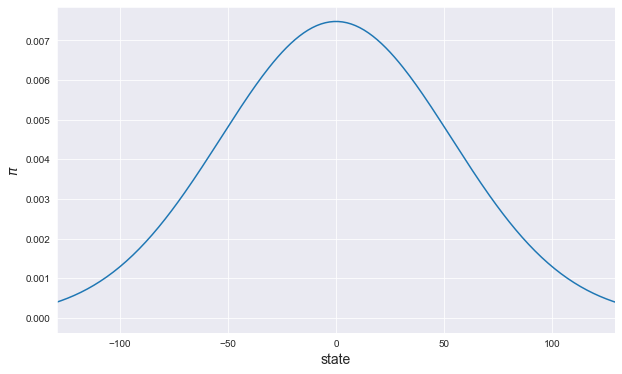

In [15]:
#Example: set params, compute matrix, compute pi, plot
n = 512
c = 20
k = 32
tmat = transitionmat_uf(n, c, k)
pi = invdis(tmat, 2*n+1)
plot_line(pi, n, n/2)

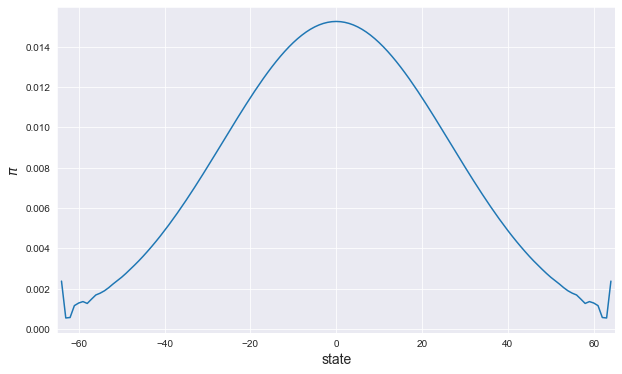

In [17]:
#Example for reflecting borders warping the distribution
n = 64
c = 128
k = 8
tmat = transitionmat_uf(n, c, k)
pi = invdis(tmat, 2*n+1)
plot_line(pi, n, n*2)

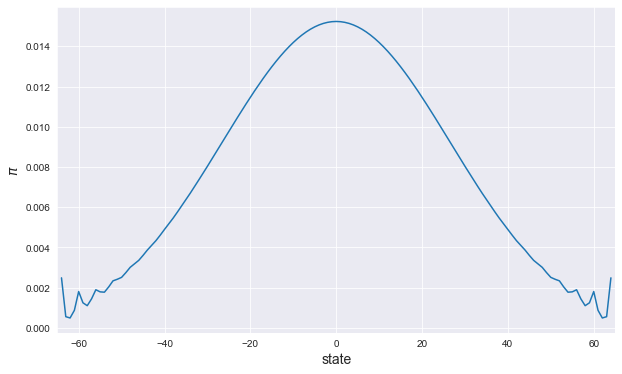

In [18]:
n = 64
c = 64
k = 8
tmat = transitionmat_uf(n, c, k)
pi = invdis(tmat, 2*n+1)
plot_line(pi, n, n*2)

In [32]:
# computing std. dev. for given parameters
n = 256
c = 256
k = 32
tmat = transitionmat_uf(n, c, k)
pi = invdis(tmat, 2*n+1)
v = n_variance(pi, n)
e_cdf = np.cumsum(pi)
v

2836.7766269469507

In [35]:
v_n = 
x = np.linspace(-n,n,n*2+1)
n_pdf = np.array([norm(0,np.sqrt(v_n)).pdf(i) for i in x])
n_cdf = np.array([norm(0,np.sqrt(v_n)).cdf(i) for i in x])
#print('Var = %f, Std = %f' % (v, np.sqrt(v)))

[]

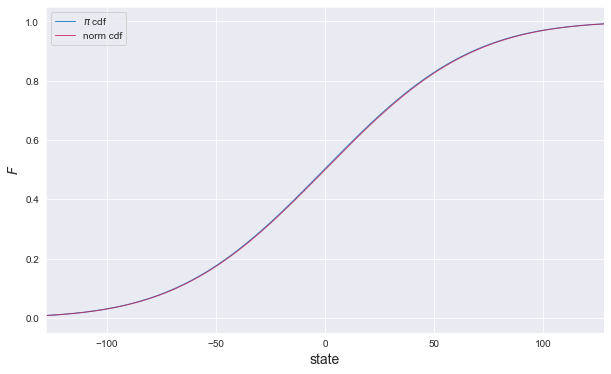

In [36]:
fig, ax = plt.pyplot.subplots(figsize=(10,6))
sns.set_style("darkgrid")
ax.set_xlabel("state", fontsize = 14)
ax.set_ylabel("$F$", fontsize = 14)
plt.pyplot.xlim([-64*2, 64*2])
ax.plot(x, e_cdf,'#0070B8', lw=1, alpha=0.8, label='$\pi$ cdf')
ax.plot(x, n_cdf,'#C21E56', lw=1, alpha=0.8, label='norm cdf')
plt.pyplot.legend()
plt.pyplot.plot()

In [37]:
max_gap = np.max(np.abs((e_cdf-n_cdf)))
arg_max = np.argmax(np.abs(e_cdf-n_cdf))
print(max_gap, arg_max-512)

0.0037687570469140397 -250


In [48]:
# check possible increments for given c, k
for k_i in range(1,8):
    for c_i in range(1,8):
        print(possible_incs(2**k_i, 2**c_i))

{1.0}
{1.0}
{1.0}
{1.0}
{1.0}
{1.0}
{1.0}
{2.0}
{2.0}
{2.0}
{2.0}
{2.0}
{2.0}
{1.0, 2.0, 3.0}
{4.0}
{4.0}
{4.0}
{4.0}
{4.0}
{3.0, 4.0, 5.0}
{3.0, 4.0, 5.0}
{8.0}
{8.0}
{8.0}
{8.0}
{8.0, 9.0, 7.0}
{8.0, 9.0, 7.0}
{5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0}
{16.0}
{16.0}
{16.0}
{16.0, 17.0, 15.0}
{16.0, 17.0, 15.0}
{13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0}
{10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0}
{32.0}
{32.0}
{32.0, 33.0, 31.0}
{32.0, 33.0, 31.0}
{32.0, 33.0, 34.0, 35.0, 29.0, 30.0, 31.0}
{32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0}
{21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0}
{64.0}
{64.0, 65.0, 63.0}
{64.0, 65.0, 63.0}
{64.0, 65.0, 66.0, 67.0, 61.0, 62.0, 63.0}
{64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0}
{52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0